In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

##### Importación de datos de stocks del ejercicio anterior (Módulo 30)

In [2]:
df_lunr = pd.read_csv('LUNR.csv')
df_rklb = pd.read_csv('RKLB.csv')

In [3]:
def nasdaq_clean(dataframe):

    dataframe = dataframe.rename(columns={'Close/Last':'Close'})

    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    
    for c in ['Close','Open','High','Low']:
        dataframe[c] = dataframe[c].str.replace('$','')
        dataframe[c] = dataframe[c].astype('float')

    dataframe.insert(0,'Volume',dataframe.pop('Volume'))

    dataframe = dataframe.set_index('Date')
    dataframe = dataframe.sort_index()

    return dataframe

In [4]:
df_lunr = nasdaq_clean(df_lunr)
df_rklb = nasdaq_clean(df_rklb)

##### Serie de Movimiento Browniano Geométrico (LUNR)

In [5]:
def simulate_1d_gbm(nsteps=1000, t=1, mu=0.0001, sigma=0.02, start=1):
    steps = [(mu - (sigma**2)/2) + np.random.randn()*sigma for i in range(nsteps)]
    y = start*np.exp(np.cumsum(steps))
    x = [t*i for i in range(nsteps)]
    return x,y

https://medium.com/@mlblogging.k/simulating-brownian-motion-and-stock-prices-using-python-17b6b4bd2a1

In [6]:
lunr_prices = np.flip(df_lunr['Close'].values)

In [7]:
lunr_logprices = np.log(lunr_prices)
lunr_logreturns = lunr_logprices[1:] - lunr_logprices[:-1]
lunr_mu = np.mean(lunr_logreturns)
lunr_sigma = np.std(lunr_logreturns)
nsteps = lunr_logprices.shape[0]

In [35]:
x, y = simulate_1d_gbm(nsteps=nsteps, mu=lunr_mu, sigma=lunr_sigma, start=lunr_prices[0])
data = {}
data['x'] = x
data['Simulation'] = y
data['LUNR'] = df_lunr['Close'].values
fig = px.line(data, x='x', y=['LUNR','Simulation'])
fig.show()

##### Modelo de Reversión a la Media

In [49]:
def mod_vasicek(r0, K, theta, sigma, T=1, N=10, seed=777):
    np.random.seed(seed)
    dt = T/float(N)
    prices = [r0]
    for i in range(N):
        dr = K*(theta-prices[-1])*dt + sigma*np.random.normal()
        prices.append(prices[-1] + dr)
    return range(N+1), prices

In [50]:
rklb_prices = np.flip(df_rklb['Close'].values)
r0 = np.mean(np.quantile(rklb_prices, 0.75))
K = 0.5
theta = np.mean(rklb_prices)
sigma = np.std(rklb_prices)
T = 5
seed = np.random.randint(100, 900)
N = 1000

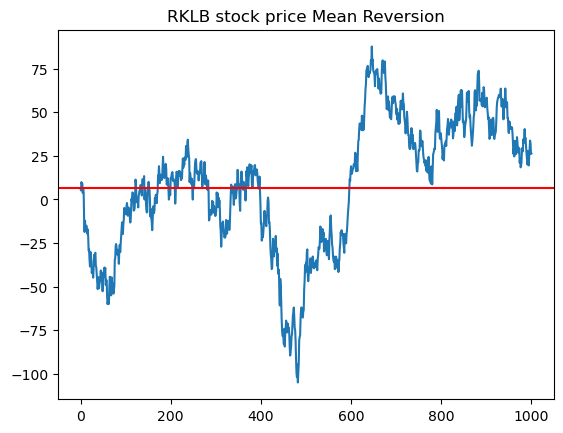

In [51]:
x, y = mod_vasicek(r0, K, theta, sigma, T, N, seed)
plt.plot(x,y)
plt.title('RKLB stock price Mean Reversion')
plt.axhline(theta, color='red')
plt.show()

##### Modelos Autoregresivo y Moving Average

In [39]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [40]:
series = df_lunr['Close']
series.index = series.index.to_period('D')

In [41]:
model = ARIMA(series, order=(1,0,0))
result = model.fit()

In [42]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  465
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -477.094
Date:                Wed, 05 Feb 2025   AIC                            960.188
Time:                        20:01:39   BIC                            972.614
Sample:                    03-01-2023   HQIC                           965.079
                         - 01-03-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0132      9.657      1.451      0.147      -4.913      32.940
ar.L1          0.9962      0.008    120.941      0.000       0.980       1.012
sigma2         0.4510      0.010     44.028      0.0

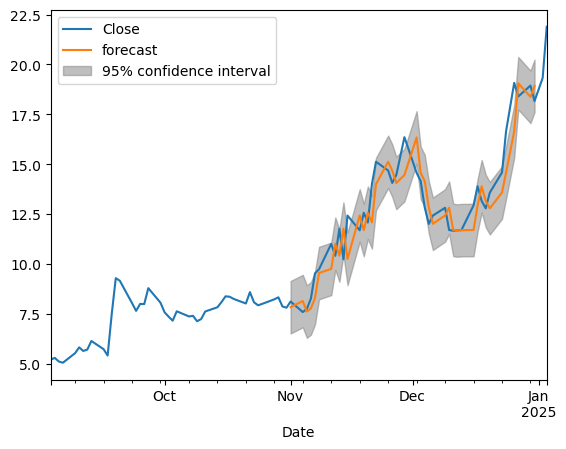

In [43]:
fig, ax = plt.subplots()
ax = series['2024-09-01':].plot(ax=ax)
plot_predict(result, '2024-11-01', '2024-12-31', ax=ax)
plt.show()

In [44]:
model = ARIMA(series, order=(0,0,1))
result = model.fit()

In [45]:
fig, ax = plt.subplots()
ax = series['2024-09-01':].plot(ax=ax)
plot_predict(result, '2024-11-01', '2024-12-31', ax=ax)
plt.show()